In [289]:
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import collections

In [695]:
import warnings
warnings.filterwarnings("ignore")

## Read fish sellings

In [787]:
ext1 = pd.read_csv('db2/Ext.csv')

In [811]:
ext2_unit = pd.read_csv('ext2_unit.csv')

In [815]:
fish = pd.read_csv('new_ext2.csv')
del fish['Unnamed: 0']

fish['unit_old'] = fish['unit'].copy()
fish['unit'] = ext2_unit['bert']
fish['date_vsd'] = pd.to_datetime(fish['date_vsd'])
fish['volume'] /= fish['unit'].apply(lambda x: 1000 if x == 'кг' else 1)
fish['bad_unit'] = fish['unit'] != fish['unit_old']
fish = fish.merge(ext1[['id_Plat', 'id_vsd']], on='id_vsd', how='left')
fish.rename(columns={'date_vsd': 'date'}, inplace=True)
fish.head()

,id_vsd,num_vsd,id_fish,fish,date,volume,unit,unit_old,bad_unit,id_Plat
0,7820377,5278887,400,минтай,2022-01-01 00:39:56,75.480,кг,\N,True,6289659.0
1,9397385,4729853,400,минтай,2022-01-01 01:34:08,62.586,кг,\N,True,6291955.0
2,8666689,3907934,292,треска,2022-01-01 01:34:11,1.155,кг,\N,True,6292599.0
3,6371297,5389594,400,минтай,2022-01-01 01:34:05,111.048,кг,\N,True,6295511.0
4,7953288,5347700,88,окунь-клювач,2022-01-01 01:34:11,1.844,кг,\N,True,6289797.0


### Find duplicates in sellings

In [816]:
def get_dublicate_anomalies(fish):
    rm_indexes = np.zeros(len(fish)).astype(bool)
    cnt = collections.defaultdict(int)
    first_entry = collections.defaultdict(int)
    for i, id_vsd in enumerate(fish['id_vsd']):
        cnt[id_vsd] += 1
        if cnt[id_vsd] >= 2:
            rm_indexes[i] = 1
        else:
            first_entry[id_vsd] = i
    
    good = fish[~rm_indexes]
    
#     for i in range(len(fish)):
#         if rm_indexes[i]:
#             rm_indexes[first_entry[fish['id_vsd'][i]]] = 1
            
    return good, fish[rm_indexes]

In [817]:
fish, bad = get_dublicate_anomalies(fish)

In [818]:
bad = bad.sort_values(by='id_vsd')
bad.head(6)

,id_vsd,num_vsd,id_fish,fish,date,volume,unit,unit_old,bad_unit,id_Plat
2598615,6297082,5352651,408,пикша свежая,2022-03-10 03:37:55,1.000,тонна,тонна,False,6296656.0
2598614,6297082,5352651,408,пикша свежая,2022-03-10 03:37:55,1.000,тонна,тонна,False,6296656.0
54852,6297082,5352651,408,пикша,2022-03-10 03:37:55,1.104,кг,\N,True,6296656.0
1781236,6297132,3224898,400,минтай,2022-03-09 04:18:55,0.181,кг,тонна,True,6292739.0
1781235,6297132,3224898,400,минтай,2022-03-09 04:18:55,0.181,кг,тонна,True,6292739.0
54124,6297132,3224898,400,минтай,2022-03-09 04:18:55,181.095,кг,\N,True,6292739.0


In [819]:
bad.to_csv('duplicates.csv', index=False)

### Add duplicates and wrong units in rating system

In [820]:
bad_units = fish.groupby(['id_Plat', fish['date'].dt.date, fish['id_fish']])['bad_unit'].sum().reset_index()
bad_units.rename(columns={'bad_unit': 'amount'}, inplace=True)
bad_units['anomaly_type'] = 'bad_unit'
bad_units.head()

,id_Plat,date,id_fish,amount,anomaly_type
0,6288840.0,2022-01-04,-1,0,bad_unit
1,6288840.0,2022-01-04,7,0,bad_unit
2,6288840.0,2022-01-04,43,0,bad_unit
3,6288840.0,2022-01-04,216,0,bad_unit
4,6288840.0,2022-01-05,-1,0,bad_unit


In [824]:
bad_units['amount'].sum()

69596

In [821]:
duplicates = bad.groupby(['id_Plat', bad['date'].dt.date, bad['id_fish']])['volume'].count().reset_index()
duplicates.rename(columns={'volume': 'amount'})
duplicates['anomaly_type'] = 'duplicate'
duplicates.head()

,id_Plat,date,id_fish,volume,anomaly_type
0,6288893.0,2022-02-05,16,2,duplicate
1,6288893.0,2022-02-05,292,1,duplicate
2,6288893.0,2022-02-05,408,3,duplicate
3,6288893.0,2022-03-07,16,2,duplicate
4,6288893.0,2022-03-07,126,2,duplicate


## Read shipment data

In [822]:
import plotly.express as px
import numpy as np

In [823]:
shipment = pd.read_csv('shipment_dates_test.csv')
shipment.columns = [el.replace('.', '_') for el in shipment.columns]
shipment.rename(columns={'prod_board_volume': 'volume'}, inplace=True)
shipment['date'] = pd.to_datetime(shipment['date'])
shipment = shipment.merge(pd.read_csv('db1/ref/prod_type.csv', sep=';')[['id_prod_type', 'id_fish']], on = 'id_prod_type')
del shipment['Unnamed: 0']
shipment.head()

,id_ves,id_prod_type,date,volume,id_fish
0,1610,10128,2022-01-07,9.385,292
1,1610,10128,2022-02-01,1.604,292
2,1610,10128,2022-02-24,3.418,292
3,1610,10128,2022-04-05,4.992,292
4,1610,10128,2022-04-21,6.247,292


### Utils for anomalies detecting

In [854]:
def find_anomalies(shipment, sell, fish_aliving=3, threshold=1000):
    shipment = shipment.copy()
    sell = sell.copy()
    
    shipment['t'] = 'shipment'
    sell['t'] = 'sells'
    sell['date'] += timedelta(seconds=1)
    
    data = pd.concat([shipment, sell], axis=0)
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(by='date')
    anomaly = {'over_sell': [], # sold more than arrived in last <fish_aliving> days
               'under_sell': [] # <fish_aliving> days has been spent, but it wasn't sold
              }
    
    for_sell = []
    sells_parts = collections.defaultdict(list)
    sum_left_in_shop = []
    uniq_dates = np.unique([data.iloc[i]['date'].strftime('%Y-%m-%d') for i in range(len(data))])
    uniq_dates = np.sort(uniq_dates)
    pt_dates = 0
    
    for i in range(len(data)):
        el = data.iloc[i]
        
        if el['t'] == 'shipment': 
            for_sell.append([el['date'], el['volume']])
            if pt_dates < len(uniq_dates) and el['date'].strftime('%Y-%m-%d') == uniq_dates[pt_dates]:
                sum_left_in_shop.append({'date': el['date'].strftime('%Y-%m-%d'), 'volume': sum([el[1] for el in for_sell])})
                pt_dates += 1
        else:
            if pt_dates < len(uniq_dates) and el['date'].strftime('%Y-%m-%d') == uniq_dates[pt_dates]:
                sum_left_in_shop.append({'date': el['date'].strftime('%Y-%m-%d'), 'volume': sum([el[1] for el in for_sell])})
                pt_dates += 1
                
            while len(for_sell) and el['date'] - for_sell[0][0] > timedelta(days=fish_aliving):
                if for_sell[0][1]:
                    now = el
                    now['volume'] = for_sell[0][1]
                    anomaly['under_sell'].append(now)
                    
                for_sell = for_sell[1:]
            
            now_parts = []
            for i in range(len(for_sell)):
                x = min(for_sell[i][1], el['volume'])
                now_parts.append({'from': for_sell[i][0].strftime('%Y-%m-%d'), 'volume': x})
                for_sell[i][1] -= x
                el['volume'] -= x
                if el['volume'] == 0:
                    break
                    
            sells_parts[el['date'].strftime('%Y-%m-%d')] += now_parts
            if el['volume'] > 0:
                anomaly['over_sell'].append(el)
    
    
    anomaly['under_sell'] = [el for el in anomaly['under_sell'] if el['volume'] > threshold]
    anomaly['over_sell'] = [el for el in anomaly['over_sell'] if el['volume'] > threshold]
    return anomaly, dict(sells_parts), pd.DataFrame(sum_left_in_shop)

In [826]:
def detect_outliers(data):
    std = data.std()
    mean = data.mean()
    return (data > mean + 2 * std) | (data < mean - 2 * std)

### Find anomalies by all fishes

In [827]:
def get_one_fish(fish_id):
    one_fish_sell = fish[fish['id_fish'] == fish_id][['date', 'volume', 'id_Plat']]
    one_fish_sell = one_fish_sell.groupby([one_fish_sell['date'].dt.date])['volume'].sum().reset_index()
    one_fish_sell['t'] = 'sells'
    
    one_fish_shipment = shipment[shipment['id_fish'] == fish_id]
    one_fish_shipment = one_fish_shipment.sort_values('date')
    one_fish_shipment = one_fish_shipment.groupby('date')['volume'].sum().reset_index()
    one_fish_shipment['t'] = 'shipment'
    return one_fish_sell, one_fish_shipment

In [835]:
one_fish_sell, one_fish_shipment = get_one_fish(400)

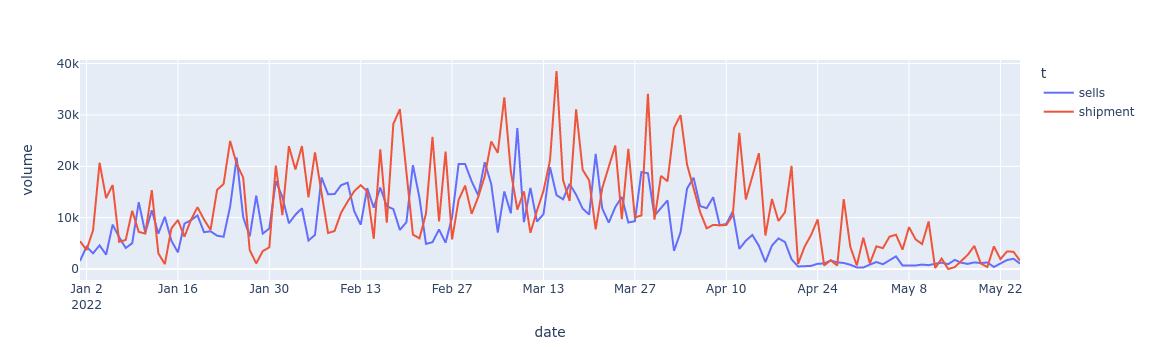

In [840]:
px.line(pd.concat([one_fish_sell, one_fish_shipment]), x='date', y='volume', color='t')

In [853]:
fish.to_csv('fish.csv', index=False)

In [864]:
sells_anomaly = pd.DataFrame(columns=['volume', 'id_Plat', 'date', 'id_fish'])
left_in_shop = pd.DataFrame(columns=['date', 'id_fish'])
shipment_not_sold = pd.DataFrame(columns=['volume', 'date', 'id_fish', 'not sold'])
parts = {}


for fish_id in tqdm(fish['id_fish'].unique()):
    one_fish_sell, one_fish_shipment = get_one_fish(fish_id)
    one_fish = pd.concat([one_fish_sell, one_fish_shipment])
    anomaly, sells_parts, sum_left_in_shop = find_anomalies(one_fish_shipment, one_fish_sell, 14, 50)
    parts[fish_id] = sells_parts
    
    one_fish_shipment['not sold'] = 0
    for el in anomaly['under_sell']:
        one_fish_shipment.loc[one_fish_shipment['date'] == el['date'], 'not sold'] = el['volume']
    
    if len(anomaly['over_sell']) == 0:
        continue
        
    over_sell = pd.DataFrame(anomaly['over_sell'])
    under_sell = pd.DataFrame(anomaly['under_sell'])
    
    full_fish = fish[fish['id_fish'] == fish_id][['date', 'volume', 'id_Plat']]
    over_sells_anomaly = over_sell[detect_outliers(over_sell['volume'])]
    add_rating = []
    for i in range(len(over_sells_anomaly)):
        el = over_sells_anomaly.iloc[i]
        day_sells = full_fish[full_fish['date'].dt.date == el['date']]
        volumes = day_sells['volume'].tolist()
        plat_ids = day_sells['id_Plat'].tolist()
        dates = day_sells['date'].tolist()
        
        pt = len(day_sells) - 1
        while pt >= 0 and el['volume'] > 0:
            el['volume'] -= volumes[pt]
            add_rating.append({'volume': volumes[pt], 'id_Plat': plat_ids[pt], 'date': dates[pt]})
            pt -= 1
            
    sum_left_in_shop['id_fish'] = fish_id
    one_fish_sell['date'] = one_fish_sell['date'].astype(str)#.strftime('%Y-%m-%d')
    sum_left_in_shop = sum_left_in_shop.merge(one_fish_sell, on='date', how='left').drop('t', axis=1)
    left_in_shop = pd.concat([left_in_shop, sum_left_in_shop])
    
    add_rating = pd.DataFrame(add_rating)
    add_rating['id_fish'] = fish_id
    sells_anomaly = pd.concat([sells_anomaly, add_rating])
    
    one_fish_shipment.drop('t', axis=1, inplace=True)
    one_fish_shipment['id_fish'] = fish_id
    shipment_not_sold = pd.concat([shipment_not_sold, one_fish_shipment])

100%|█████████████████████████████████████████| 243/243 [00:24<00:00,  9.94it/s]


In [865]:
import pickle

with open('selling_parts.pickle', 'wb') as fp:
    pickle.dump(parts, fp)

In [866]:
sells_anomaly = sells_anomaly.groupby(['id_Plat', sells_anomaly['date'].dt.date, 'id_fish'])['volume'].sum().reset_index()
sells_anomaly['anomaly_type'] = 'over_sells'
sells_anomaly.head()

,id_Plat,date,id_fish,volume,anomaly_type
0,6288840.0,2022-01-26,43,0.087,over_sells
1,6288840.0,2022-01-27,248,0.027,over_sells
2,6288840.0,2022-01-28,7,0.180,over_sells
3,6288840.0,2022-02-07,43,0.050,over_sells
4,6288840.0,2022-02-10,-1,0.028,over_sells


In [867]:
shipment_not_sold.to_csv('shipment_not_sold.csv', index=False)
shipment_not_sold.head()

,volume,date,id_fish,not sold
0,5427.243552,2022-01-01,400,0
1,3697.807036,2022-01-02,400,0
2,7534.925352,2022-01-03,400,0
3,20687.523994,2022-01-04,400,0
4,13809.358200,2022-01-05,400,0


In [868]:
rating = pd.concat([bad_units, duplicates, sells_anomaly])
rating.shape

(1101701, 6)

In [869]:
rating.to_csv('rating.csv')